# Multi-Label Classification

## 1. Imports

In [1]:
import ast
import random
import re
import string
from collections import Counter
from pathlib import Path
from typing import Any, Union, Optional, Callable

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import asarray
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from tqdm.contrib.itertools import product
from tqdm.notebook import tqdm
from wordcloud import WordCloud

import MLC

## 2. Configurations & Constants

### Global Configuration Constants

In [2]:
OVERWRITE = False
RETRAIN = False
RANDOM_STATE = 42
MODEL_LEVEL = "general"

### Set Random Seeds

In [3]:
np.random.seed(seed=RANDOM_STATE)
random.seed(a=RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    "computer security": "computer security",
    "operating systems": "operating systems",
    "software": "software",
    "programming languages": "software",
    "hardware": "hardware",
    "electronic components": "hardware",
    "networking": "networking",
    "internet technology": "networking",
}

### Directory Paths

In [6]:
COLAB_DIR = Path("/content/drive/MyDrive")
KAGGLE_DIR = Path("/kaggle/input")
LOCAL_DIR = Path("./")

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / "data"
    MODELS_DIR = COLAB_DIR / "models"
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / "data"
    MODELS_DIR = LOCAL_DIR / "models"

### Dataset & Model Paths

In [7]:
TWEETS_CSV = DATA_DIR / "tweets-dataset/categories_train.csv"
GENERAL_PKL = MODELS_DIR / "general.pkl"

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest are:
1. computer security/network security
2. computer security/antivirus and malware
3. operating systems/mac os
4. operating systems/windows
5. operating systems/unix
6. operating systems/linux
7. software
8. programming languages, included in software
9. software/databases
10. hardware
11. electronic components, included in hardware
12. hardware/computer/servers
13. hardware/computer/portable computer
14. hardware/computer/desktop computer
15. hardware/computer components
16. hardware/computer networking/router
17. hardware/computer networking/wireless technology
18. networking
19. internet technology, included in networking

In [8]:
with open(TWEETS_CSV, "rb") as f:
    tweets = pd.read_csv(f)

tweets = tweets.assign(
    tweet=lambda df: df["tweet"].apply(func=ast.literal_eval),
    watson=lambda df: df["watson"].apply(func=ast.literal_eval),
    urls=lambda df: df["urls"].apply(func=ast.literal_eval),
    watson_list=lambda df: df["watson_list"].apply(func=ast.literal_eval),
    target=lambda df: df["target"].apply(func=ast.literal_eval),
)

tweets.head()

,Unnamed: 0,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate,watson_list,target
0,2281,b'5b90d2b7bb325e7007186abf',2018-09-06 07:09:42+00:00,1037598700468686848,True,SQL Injection Attack – Ethical Hacking Course ...,{'created_at': 'Thu Sep 06 07:09:42 +0000 2018...,general,{'technology and computing': {'computer securi...,NaN,[https://mindchow.club/sql-injection-attack-et...,NaN,False,"[technology and computing, computer security, ...","[computer security, antivirus and malware]"
1,6466,b'5b9249fabb325e70071883b7',2018-09-07 09:50:49+00:00,1038001634872381440,False,A wise minister should deliberately play down ...,{'created_at': 'Fri Sep 07 09:50:49 +0000 2018...,vulnerability,{'technology and computing': {'computer securi...,irrelevant,[https://twitter.com/i/web/status/103800163487...,https://twitter.com/i/web/status/1038001634872...,True,"[technology and computing, computer security, ...","[network security, computer security, antiviru..."
2,6283,b'5b9236a0bb325e70071882b0',2018-09-07 08:28:08+00:00,1037980825021603840,True,"Ransomware down, but not out, report reveals h...",{'created_at': 'Fri Sep 07 08:28:08 +0000 2018...,ransomware,{'business and industrial': {'company': {'annu...,threat,[http://dlvr.it/QjPqHc],https://www.computerweekly.com/news/252448202/...,True,"[business and industrial, company, annual repo...","[software, databases]"
3,8183,b'5b92c4abbb325e521c5ae3b0',2018-09-07 18:34:18+00:00,1038133374869590016,True,"""Similar to the registration-hijacking attack,...",{'created_at': 'Fri Sep 07 18:34:18 +0000 2018...,general,{'health and fitness': {'addiction': {'alcohol...,threat,[https://twitter.com/i/web/status/103813337486...,https://twitter.com/i/web/status/1038133374869...,True,"[health and fitness, addiction, alcoholism, di...",[other]
4,14348,b'5b973fcebb325e7a2e19a110',2018-09-11 04:08:45+00:00,1039365103026667521,True,"CVE-2018-16768\n\nIn WAVM through 2018-07-26, ...",{'created_at': 'Tue Sep 11 04:08:45 +0000 2018...,general,{'technology and computing': {'programming lan...,threat,[https://twitter.com/i/web/status/103936510302...,https://twitter.com/i/web/status/1039365103026...,True,"[technology and computing, programming languag...","[software, networking]"


In [9]:
def map_targets(watson_list, fix_targets):
    targets = set(fix_targets.keys()) & set(watson_list)
    mapped_targets = {fix_targets[category] for category in targets}
    return list(mapped_targets) if mapped_targets else ["other"]


tweets = tweets.assign(
    target=lambda df: df["target"].apply(func=map_targets, args=(FIX_TARGETS,))
)
# tweets['text'] = [replace_text_components(t) for t in tweets['text']]
# tweets['text'] = [clean_text(t) for t in tweets['text']]
# tweets['text'] = [lemmatize_text(t) for t in tweets['text']]
# tweets['text'] = [remove_stopwords(t) for t in tweets['text']]

print(f"Threat Tweets: {len(tweets)}")
tweets.head()

Threat Tweets: 12290


,Unnamed: 0,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate,watson_list,target
0,2281,b'5b90d2b7bb325e7007186abf',2018-09-06 07:09:42+00:00,1037598700468686848,True,SQL Injection Attack – Ethical Hacking Course ...,{'created_at': 'Thu Sep 06 07:09:42 +0000 2018...,general,{'technology and computing': {'computer securi...,NaN,[https://mindchow.club/sql-injection-attack-et...,NaN,False,"[technology and computing, computer security, ...",[computer security]
1,6466,b'5b9249fabb325e70071883b7',2018-09-07 09:50:49+00:00,1038001634872381440,False,A wise minister should deliberately play down ...,{'created_at': 'Fri Sep 07 09:50:49 +0000 2018...,vulnerability,{'technology and computing': {'computer securi...,irrelevant,[https://twitter.com/i/web/status/103800163487...,https://twitter.com/i/web/status/1038001634872...,True,"[technology and computing, computer security, ...",[computer security]
2,6283,b'5b9236a0bb325e70071882b0',2018-09-07 08:28:08+00:00,1037980825021603840,True,"Ransomware down, but not out, report reveals h...",{'created_at': 'Fri Sep 07 08:28:08 +0000 2018...,ransomware,{'business and industrial': {'company': {'annu...,threat,[http://dlvr.it/QjPqHc],https://www.computerweekly.com/news/252448202/...,True,"[business and industrial, company, annual repo...",[software]
3,8183,b'5b92c4abbb325e521c5ae3b0',2018-09-07 18:34:18+00:00,1038133374869590016,True,"""Similar to the registration-hijacking attack,...",{'created_at': 'Fri Sep 07 18:34:18 +0000 2018...,general,{'health and fitness': {'addiction': {'alcohol...,threat,[https://twitter.com/i/web/status/103813337486...,https://twitter.com/i/web/status/1038133374869...,True,"[health and fitness, addiction, alcoholism, di...",[other]
4,14348,b'5b973fcebb325e7a2e19a110',2018-09-11 04:08:45+00:00,1039365103026667521,True,"CVE-2018-16768\n\nIn WAVM through 2018-07-26, ...",{'created_at': 'Tue Sep 11 04:08:45 +0000 2018...,general,{'technology and computing': {'programming lan...,threat,[https://twitter.com/i/web/status/103936510302...,https://twitter.com/i/web/status/1039365103026...,True,"[technology and computing, programming languag...","[networking, software]"


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [10]:
all_words = " ".join(tweets["text"]).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('the', 3224), ('to', 2944), ('a', 2873), ('of', 2602), ('in', 2380), ('and', 2325), ('vulnerability', 2163), ('-', 1853), ('is', 1637), ('Vulnerability', 1533)]


#### 4.1.2. Word Cloud

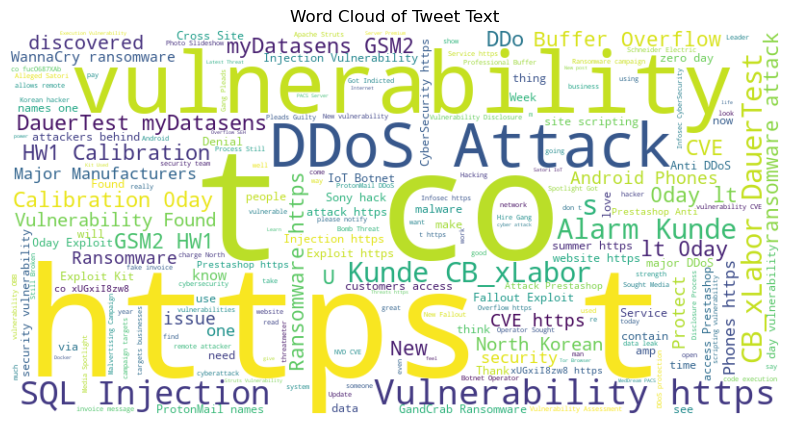

In [11]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    text=" ".join(tweets["text"])
)
plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Tweet Text")
plt.show()

#### 4.1.3. Text Length Distribution

/home/irfeazy/.local/my_programs/anaconda3/envs/vsc/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


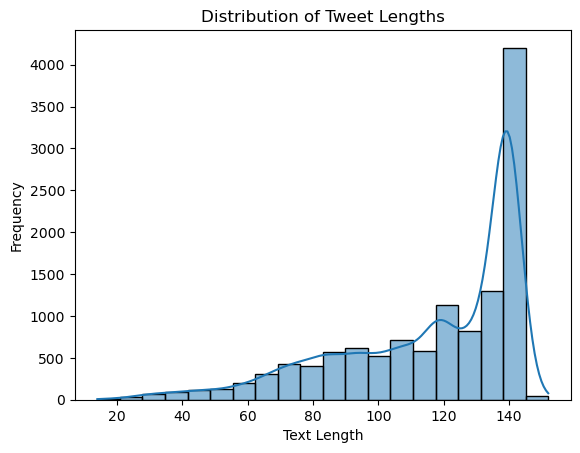

In [12]:
tweets["text_length"] = tweets["text"].apply(func=len)
sns.histplot(data=tweets["text_length"], bins=20, kde=True)
plt.title(label="Distribution of Tweet Lengths")
plt.xlabel(xlabel="Text Length")
plt.ylabel(ylabel="Frequency")
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [13]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in tweets["watson_list"] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 11470), ('computer security', 7279), ('antivirus and malware', 4625), ('software', 3768), ('network security', 3420), ('hardware', 2208), ('society', 2045), ('business and industrial', 1775), ('computer', 1706), ('crime', 1500)]


/home/irfeazy/.local/my_programs/anaconda3/envs/vsc/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


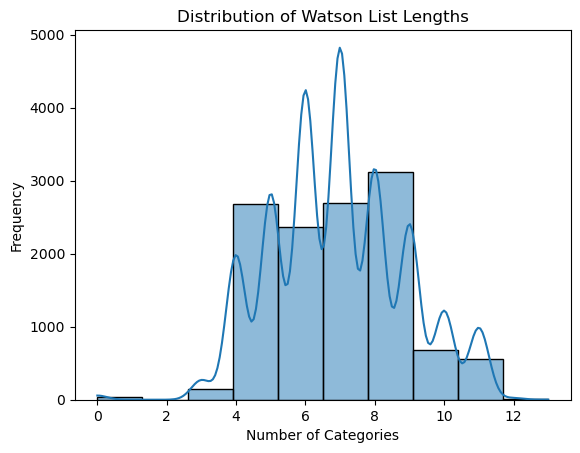

In [14]:
# Category Depth Analysis
tweets["watson_list_length"] = tweets["watson_list"].apply(func=len)
sns.histplot(data=tweets["watson_list_length"], bins=10, kde=True)
plt.title(label="Distribution of Watson List Lengths")
plt.xlabel(xlabel="Number of Categories")
plt.ylabel(ylabel="Frequency")
plt.show()

In [15]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in tweets["watson_list"]:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'computer security'), 7279), (('technology and computing', 'antivirus and malware'), 4625), (('computer security', 'antivirus and malware'), 4625), (('technology and computing', 'software'), 3768), (('technology and computing', 'network security'), 3420), (('computer security', 'network security'), 3420), (('technology and computing', 'hardware'), 2208), (('technology and computing', 'computer'), 1706), (('hardware', 'computer'), 1706), (('society', 'crime'), 1500)]


In [16]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('technology', 11470), ('computer', 10124), ('antivirus', 4625), ('software', 3771), ('network', 3504), ('hardware', 2208), ('society', 2045), ('business', 1995), ('crime', 1500), ('databases', 1475), ('art', 1435), ('law,', 1425), ('consumer', 1229), ('science', 1213), ('health', 1104), ('operating', 911), ('personal', 900), ('home', 894), ('programming', 841), ('property', 750), ('movies', 628), ('hobbies', 604), ('internet', 568), ('government', 565), ('javascript', 495), ('networking', 494), ('tv', 444), ('finance', 441), ('vpn', 432), ('disorders', 430), ('sports', 415), ('legal', 413), ('physics', 400), ('telephones', 397), ('mobile', 393), ('linux', 390), ('assault', 390), ('travel', 383), ('music', 379), ('optics', 373), ('burglary', 367), ('smart', 363), ('disease', 357), ('food', 347), ('mental', 308), ('company', 307), ('law', 303), ('kidnapping', 290), ('social', 285), ('weather', 280), ('legislation', 266), ('meteorological', 261), ('window

### 4.4. Target Analysis

Target Frequencies:
computer security: 7279
software: 4096
hardware: 2263
other: 1804
networking: 1026
operating systems: 911


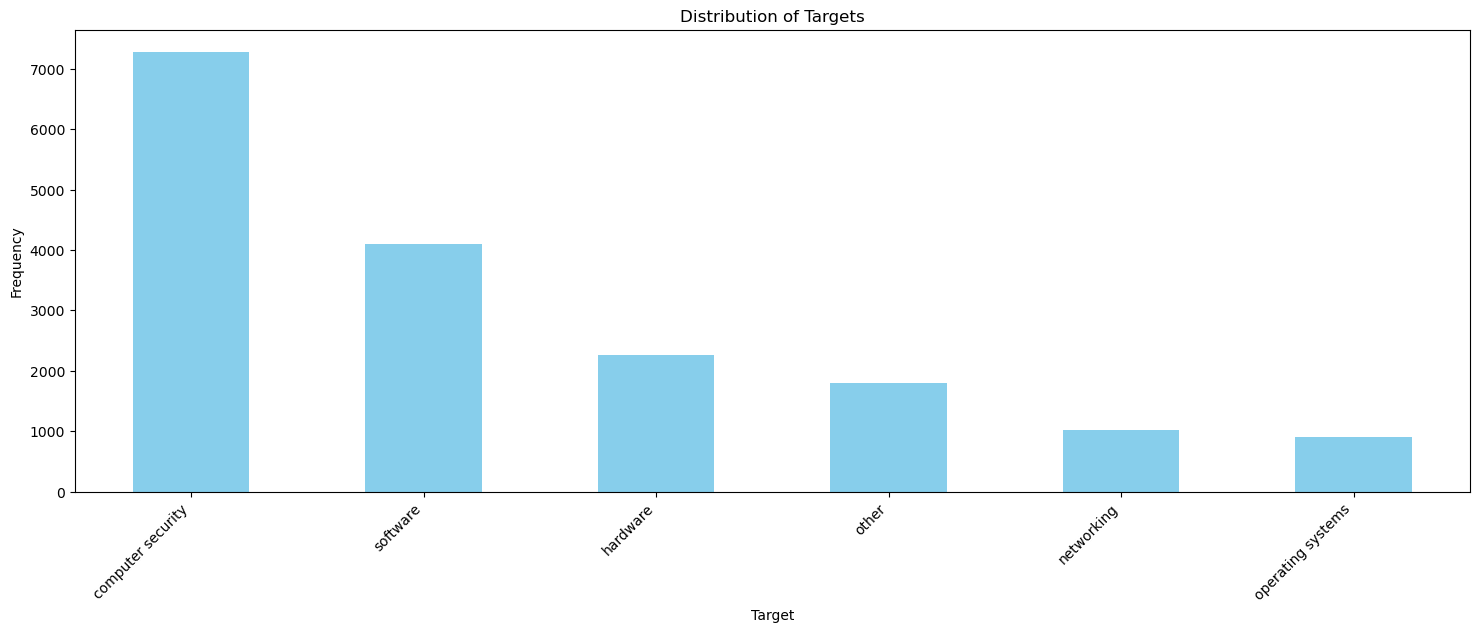

In [17]:
class_freq = Counter([item for sublist in tweets["target"] for item in sublist])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(
    kind="bar", color="skyblue"
)
plt.title("Distribution of Targets")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer security',): 4126
('other',): 1804
('computer security', 'software'): 1499
('software',): 937
('hardware',): 692
('computer security', 'hardware'): 616
('software', 'hardware'): 423
('operating systems', 'software'): 348
('networking',): 305
('computer security', 'software', 'hardware'): 260
('computer security', 'networking', 'software'): 213
('computer security', 'networking'): 189
('operating systems', 'computer security', 'software'): 166
('networking', 'software'): 162
('operating systems',): 154
('operating systems', 'computer security'): 120
('computer security', 'networking', 'hardware'): 67
('networking', 'hardware'): 61
('operating systems', 'software', 'hardware'): 59
('operating systems', 'hardware'): 37
('networking', 'software', 'hardware'): 25
('operating systems', 'computer security', 'hardware'): 23
('operating systems', 'networking', 'software'): 4


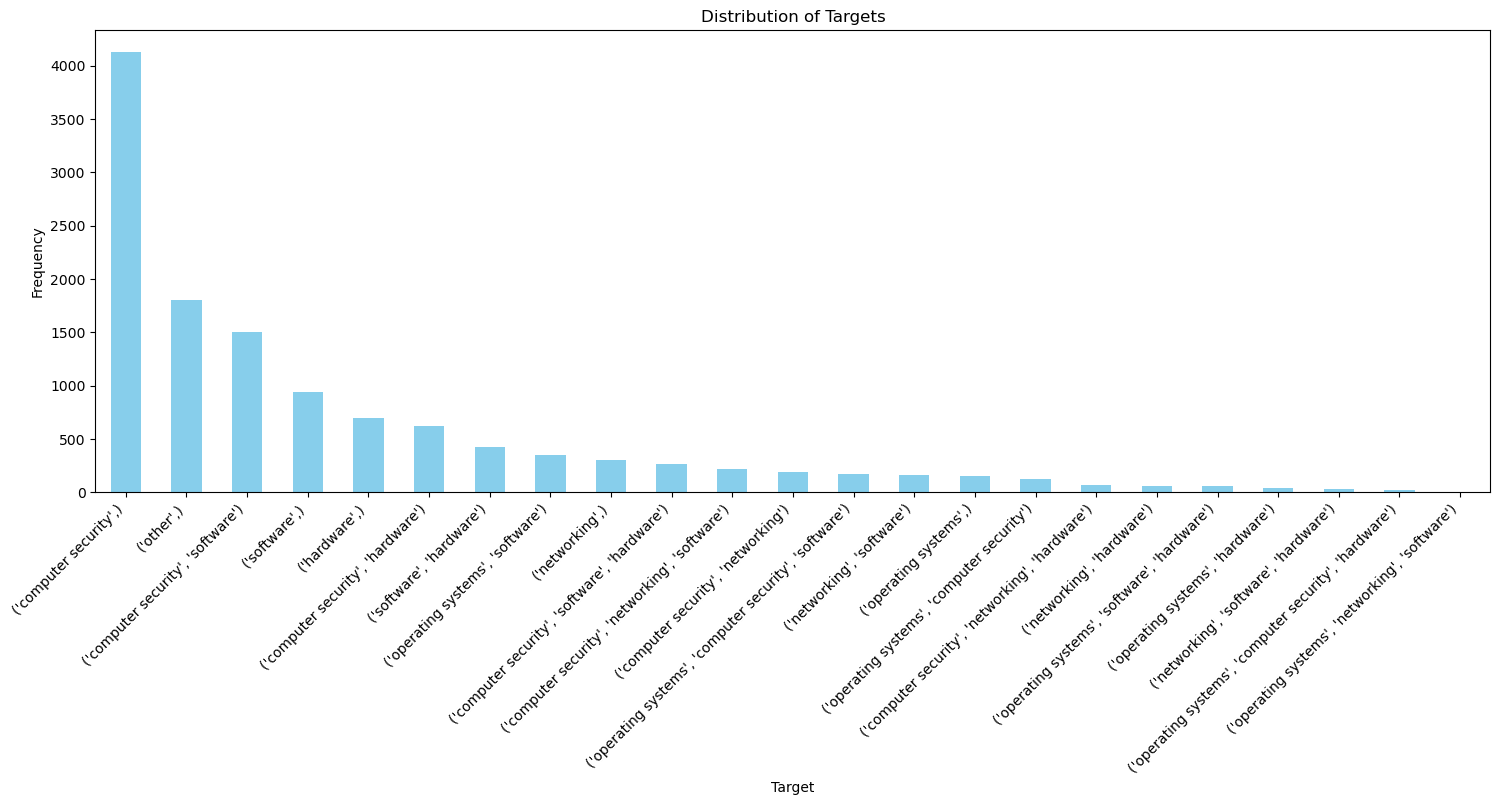

In [18]:
target_freq = Counter(tuple(item) for item in tweets["target"])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(
    pd.Series(data={str(k): v for k, v in target_freq.items()})
    .sort_values(ascending=False)
    .plot(kind="bar", color="skyblue")
)

plt.title("Distribution of Targets")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [19]:
# Multi-Label Analysis
multi_label_counts = tweets["target"].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 4272


In [20]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(tweets["target"], tweets["text"])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=["target", "text"])

for target in class_freq:
    target_texts = target_text_df[
        target_text_df["target"].apply(func=lambda x: target in x)
    ]["text"]
    vectorizer = CountVectorizer(stop_words="english")
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(
        data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out()
    )
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'computer security':
https            6942
vulnerability    3503
ddos             1483
ransomware        918
security          834
attack            533
2018              485
injection         481
botnet            458
cve               458
dtype: int64
Top 10 words for target 'software':
https            4457
vulnerability    1899
cve               770
2018              720
injection         526
sql               498
security          456
ransomware        344
exploit           315
overflow          284
dtype: int64
Top 10 words for target 'other':
https          1572
0day            755
ransomware      601
2018            475
00              404
lt              370
alarm           364
calibration     364
cb_xlabor       364
dauertest       364
dtype: int64
Top 10 words for target 'networking':
https            1142
vulnerability     286
2018              248
cve               233
prestashop        204
ddos              163
attack            136
access         

## 5. Feature Engineering

In [21]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = tweets[tweets["target"].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df["target"])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('computer security',): 4126
('other',): 1804
('computer security', 'software'): 1499
('software',): 937
('hardware',): 692
('computer security', 'hardware'): 616
('software', 'hardware'): 423
('operating systems', 'software'): 348
('networking',): 305
('computer security', 'software', 'hardware'): 260
('computer security', 'networking', 'software'): 213
('computer security', 'networking'): 189
('operating systems', 'computer security', 'software'): 166
('networking', 'software'): 162
('operating systems',): 154
('operating systems', 'computer security'): 120
('computer security', 'networking', 'hardware'): 67
('networking', 'hardware'): 61
('operating systems', 'software', 'hardware'): 59
('operating systems', 'hardware'): 37
('networking', 'software', 'hardware'): 25
('operating systems', 'computer security', 'hardware'): 23


Preprocess the `text` column into embeddings

In [22]:
def load_word2vec_dict(
    model_path: Path, embedding_dim: int
) -> dict[Union[str, list[str]], np.ndarray[Any, np.dtype]]:
    embeddings_dict = {}
    f = open(model_path, "r", encoding="utf-8")
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = " ".join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()
    return embeddings_dict


def tokenizer_transform(
    x: pd.Series,
    embedder_addr: str,
    preprocessing_list: Optional[list[Callable[[str], str]]] = None,
) -> np.ndarray[Any, np.dtype[Any]]:
    """
    Generate embeddings for the sentences in the DataFrame.

    Parameters
    ----------
    x : pd.Series
        The DataFrame containing the sentences.
    embedder_addr : str
        Address of the embedder.
    preprocessing_list : Optional[list[Callable[[str], str]]]
        List of functions to apply to each sentence.

    Returns
    -------
    encoded_sentences : ArrayLike

    """
    # Preprocess the text
    sentences = x.tolist()

    if preprocessing_list is None:
        preprocessing_list = []

    for preprocessor in preprocessing_list:
        sentences = [preprocessor(s) for s in sentences]

    model = SentenceTransformer(model_name_or_path=embedder_addr)
    return model.encode(sentences)


def preprocess_texts(list_str, model_path, embedding_dim):
    if embedding_dim is None:
        return tokenizer_transform(x=list_str, embedder_addr=model_path)

    word2vec_dict = load_word2vec_dict(
        model_path=model_path, embedding_dim=embedding_dim
    )
    list_embedded_str = np.zeros((len(list_str), embedding_dim))

    for i, text in enumerate(list_str):
        tokens = re.findall(r"\w+|[{}]".format(re.escape(string.punctuation)), text)
        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue

    return list_embedded_str

In [23]:
texts = filtered_df["text"]
targets = filtered_df["text"]

Convert the `target` column into a binary multi-label matrix

In [24]:
mlb = preprocessing.MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df["target"])

Create a dictionary that maps label indices to unique label sets

In [25]:
targets_list_mcp, y_mcp = np.unique(ar=y, axis=0, return_inverse=True)
targets_dict_mcp = {i: tuple(lbl_set) for i, lbl_set in enumerate(targets_list_mcp)}

## 6. Model Training

In [26]:
METHODS = {
    "br": MLC.BRClassifier,
    "clr": MLC.CLRClassifier,
    "cc": MLC.CCClassifier,
    "lp": MLC.LPClassifier,
    "pst": MLC.PStClassifier,
    #'cdn': MLC.CDNClassifier,
    "mbr": MLC.MBRClassifier,
    "rakel": MLC.RAkELClassifier,
    "homer": MLC.HOMERClassifier,
}

CLASSIFIERS = {
    "lr": LogisticRegression(solver="liblinear", max_iter=10000),
    "gnb": GaussianNB(),
    "dt": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(random_state=RANDOM_STATE),
    #'xgb': XGBClassifier(random_state=RANDOM_STATE)
}

EMBEDDERS = [
    {
        "name": "GloVe.6B.50D",
        "model-path": "embedders/glove.6B.50d.txt",
        "embedding-dim": 50,
    },
    {
        "name": "GloVe.6B.100D",
        "model-path": "embedders/glove.6B.100d.txt",
        "embedding-dim": 100,
    },
    {
        "name": "GloVe.6B.200D",
        "model-path": "embedders/glove.6B.200d.txt",
        "embedding-dim": 200,
    },
    {
        "name": "GloVe.6B.300D",
        "model-path": "embedders/glove.6B.300d.txt",
        "embedding-dim": 300,
    },
    {
        "name": "DistilRoBERTa",
        "model-path": "sentence-transformers/all-distilroberta-v1",
        "embedding-dim": None,
    },
    {
        "name": "SBERT",
        "model-path": "sentence-transformers/all-mpnet-base-v2",
        "embedding-dim": None,
    },
    {"name": "ATT&CK-BERT", "model-path": "basel/ATTACK-BERT", "embedding-dim": None},
]

In [ ]:
general_models = {}

for embedder in tqdm(EMBEDDERS, desc="Embedders", unit="embedder"):
    x = preprocess_texts(
        list_str=texts,
        model_path=embedder["model-path"],
        embedding_dim=embedder["embedding-dim"],
    )
    X_train, X_val, y_train, y_val = train_test_split(
        x,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        shuffle=True,
        stratify=y_mcp,
    )
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    models_to_embedder = []
    for name_method, name_classifier in product(
        METHODS, CLASSIFIERS, desc="Methods & Classifiers", unit="pair"
    ):
        model = METHODS[name_method](CLASSIFIERS[name_classifier])
        try:
            model.fit(X_train, y_train)
            name_model = (
                f"{name_method.upper()}[{name_classifier.upper()}] - {embedder['name']}"
            )
        except Exception as e:
            print(f"{model} failed to fit due to {e}")
            name_model = None
            continue
        if name_model is not None:
            models_to_embedder.append(name_model)
            general_models[name_model] = {
                "model": model,
                "assess": model.evaluate(X_val, y_val),
            }
    best_model = {}
    for name_model in models_to_embedder:
        temp_performance = general_models[name_model]["assess"]["report"][
            "weighted avg"
        ]["f1-score"]
        if len(best_model) == 0:
            best_model["name"] = name_model
            best_model["performance"] = temp_performance
        else:
            if best_model["performance"] < temp_performance:
                best_model["name"] = name_model
                best_model["performance"] = temp_performance
    print(f"{best_model['name']} - Performance:\t{best_model['performance']*100:.2f}%")
    report = (
        pd.DataFrame(general_models[best_model["name"]]["assess"]["report"])
        .transpose()
        .map(lambda x: f"{x:.2f}" if isinstance(x, float) else x)
        .to_string()
    )
    print(f"{report}")
    print(
        f"Accuracy:\t{general_models[best_model['name']]['assess']['accuracy']*100:.2f}%"
    )

Embedders:   0%|          | 0/7 [00:00<?, ?embedder/s]

Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

HOMERClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                  solver='liblinear')) failed to fit due to This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
HOMER[RF] - GloVe.6B.50D - Performance:	75.28%
             precision recall f1-score  support   auc
0                 0.81   0.93     0.87  1457.00  0.81
1                 0.93   0.44     0.60   452.00  0.72
2                 0.95   0.40     0.56   204.00  0.70
3                 0.98   0.47     0.64   182.00  0.74
4                 0.98   0.46     0.63   361.00  0.73
5                 0.89   0.67     0.77   819.00  0.82
micro avg         0.85   0.70     0.77  3475.00  0.83
macro avg         0.92   0.56     0.68  3475.00  0.75
weighted avg      0.88   0.70     0.75  3475.00  0.78
samples avg       0.76   0.71     0.72  3475.00  0.84
Accuracy:	61.96%


Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

In [ ]:
best_model = {}

for name_model in general_models:
    print("==========================================================")
    print(name_model)
    print(f"Accuracy:\t{general_models[name_model]['assess']['accuracy']*100:.2f}%")
    print(f"AUC micro:\t{general_models[name_model]['assess']['auc_micro']*100:.2f}%")
    print(f"AUC macro:\t{general_models[name_model]['assess']['auc_macro']*100:.2f}%")
    print(
        f"AUC weighted:\t{general_models[name_model]['assess']['auc_weighted']*100:.2f}%"
    )
    print(f"Hamming Loss:\t{general_models[name_model]['assess']['hamming_loss']:.3f}")
    print(f"\n{general_models[name_model]['assess']['report']}\n")
    temp_performance = (
        general_models[name_model]["assess"]["accuracy"]
        + general_models[name_model]["assess"]["auc_micro"]
        + general_models[name_model]["assess"]["auc_macro"]
        + general_models[name_model]["assess"]["auc_weighted"]
    ) / 4.0
    if len(best_model) == 0:
        best_model["name"] = name_model
        best_model["performance"] = temp_performance
    else:
        if best_model["performance"] < temp_performance:
            best_model["name"] = name_model
            best_model["performance"] = temp_performance

chosen_model = general_models[best_model["name"]]["model"]
print(f"{best_model['name']} - Performance:\t{best_model['performance']}")
chosen_model